[![Py4Life](https://raw.githubusercontent.com/Py4Life/TAU2015/gh-pages/img/Py4Life-logo-small.png)](http://py4life.github.io/TAU2015/)
## Lecture 10 - 27.5.2015
### Last update: 27.4.2015
### Tel-Aviv University / 0411-3122 / Spring 2015

In [3]:
%matplotlib inline
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
import os.path
import zipfile
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import linregress
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette("Set1", 8, .75)

# Population dynamics - growth curves

Our first order of business is modeling population growth. We will use data from the [World Bank](http://www.worldbank.org/) on the [population size of countries](http://data.worldbank.org/indicator/SP.POP.TOTL) around the world from 1960 until 2013.

## Data loading and cleaning

In [2]:
HTML('<blockquote class="twitter-tweet" lang="he"><p>In Data Science, 80% of time spent prepare data, 20% of time spent complain about need for prepare data.</p>&mdash; Big Data Borat (@BigDataBorat) <a href="https://twitter.com/BigDataBorat/status/306596352991830016">פברואר 27, 2013</a></blockquote><script async src="//platform.twitter.com/widgets.js" charset="utf-8"></script>')

Start by retrieving the data as a zip file (if not already downloaded):

In [3]:
fname = 'world_growth.zip'
if not os.path.exists(fname):
    url.request.urlretrieve('http://api.worldbank.org/v2/en/indicator/sp.pop.totl?downloadformat=csv', fname)

Open the file using the `zipfile` module and read it using _pandas_, skipping the first two rows and dropping the last two columns that have `NaN` values:

In [4]:
with zipfile.ZipFile('world_growth.zip') as z:
    f = z.open('sp.pop.totl_Indicator_en_csv_v2.csv')
    df = pd.read_csv(f, skiprows=2)
df.drop('2014', axis=1, inplace=True)
df.drop('Unnamed: 59', axis=1, inplace=True)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208,55435,56226,56697,57029,57360,...,98742,100031,100830,101219,101344,101418,101597,101932,102384,102911
1,Andorra,AND,"Population, total",SP.POP.TOTL,13414,14376,15376,16410,17470,18551,...,79060,81223,81877,81292,79969,78659,77907,77865,78360,79218
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8774440,8953544,9141783,9339507,9547131,9765015,...,24018682,24860855,25631282,26349243,27032197,27708187,28397812,29105480,29824536,30551674
3,Angola,AGO,"Population, total",SP.POP.TOTL,4965988,5056688,5150076,5245015,5339893,5433841,...,15976715,16544376,17122409,17712824,18314441,18926650,19549124,20180490,20820525,21471618
4,Albania,ALB,"Population, total",SP.POP.TOTL,1608800,1659800,1711319,1762621,1814135,1864791,...,3026939,3011487,2992547,2970017,2947314,2927519,2913021,2904780,2900489,2897366


In [5]:
df.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
243,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5099785,5184477,5276093,5372934,5472775,5573959,...,19612696,20139661,20661714,21182162,21703571,22229625,22763008,23304206,23852409,24407381
244,South Africa,ZAF,"Population, total",SP.POP.TOTL,17396000,17949962,18459442,18936138,19390554,19832000,...,46727694,47349013,47991699,48656506,49344228,50055701,50791808,51553479,52341695,53157490
245,"Congo, Dem. Rep.",COD,"Population, total",SP.POP.TOTL,15248246,15637715,16041247,16461914,16903899,17369859,...,52487293,54028003,55590838,57187942,58819038,60486276,62191161,63931512,65705093,67513677
246,Zambia,ZMB,"Population, total",SP.POP.TOTL,3082627,3173662,3269151,3368961,3472843,3580708,...,11174650,11470022,11781612,12109620,12456527,12825031,13216985,13633796,14075099,14538640
247,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,3752390,3876638,4006261,4140802,4279559,4422129,...,12693047,12710589,12724308,12740160,12784041,12888918,13076978,13358738,13724317,14149648


We now want to transform the dataset to a **DataFrame** format. This means that every row in the table has exactly one measurement - in our case, population size -- together with all the relevant variables: mainly country name and year.

We do this using  _pandas_ `melt` function: 

In [6]:
df = pd.melt(df, id_vars=('Country Name','Country Code','Indicator Name', 'Indicator Code'), var_name='Year', value_name='Population')
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54208
1,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13414
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8774440
3,Angola,AGO,"Population, total",SP.POP.TOTL,1960,4965988
4,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800


In [7]:
df.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
13387,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,2013,24407381
13388,South Africa,ZAF,"Population, total",SP.POP.TOTL,2013,53157490
13389,"Congo, Dem. Rep.",COD,"Population, total",SP.POP.TOTL,2013,67513677
13390,Zambia,ZMB,"Population, total",SP.POP.TOTL,2013,14538640
13391,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,2013,14149648


We get rid of rows that have `NA` values:

In [8]:
df.dropna(axis=0, inplace=True)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54208
1,Andorra,AND,"Population, total",SP.POP.TOTL,1960,13414
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8774440
3,Angola,AGO,"Population, total",SP.POP.TOTL,1960,4965988
4,Albania,ALB,"Population, total",SP.POP.TOTL,1960,1608800


Note that for some reason the `Year` variable has a type `O` (object?) instead of `int`, so we change that:

In [9]:
print(df.Year.dtype, df.Population.dtype)
df.Year = df.Year.astype(int)
print(df.Year.dtype, df.Population.dtype)

object float64
int32 float64


## Data exploration with plots

Let's start with the three biggest population in the dataset - the entire world, China and India.
We will plot their population size over time:

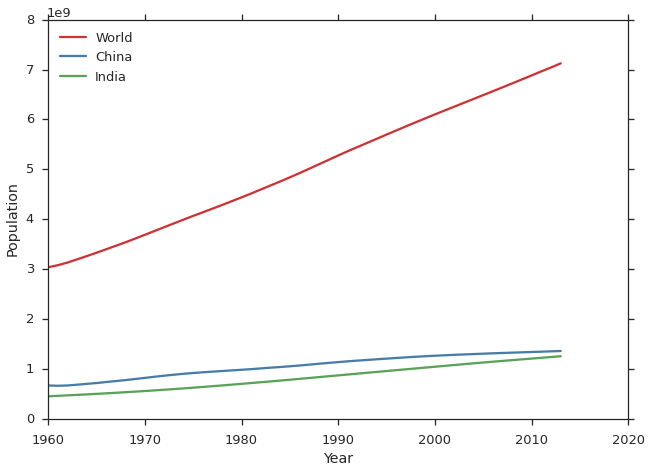

In [10]:
world = df[df['Country Name'] == 'World']
china = df[df['Country Name'] == 'China']
india = df[df['Country Name'] == 'India']

plt.plot(world.Year, world.Population, label='World')
plt.plot(china.Year, china.Population, label='China')
plt.plot(india.Year, india.Population, label='India')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Population');

Alternatively we can also plot using the `DataFrame.plot` method:

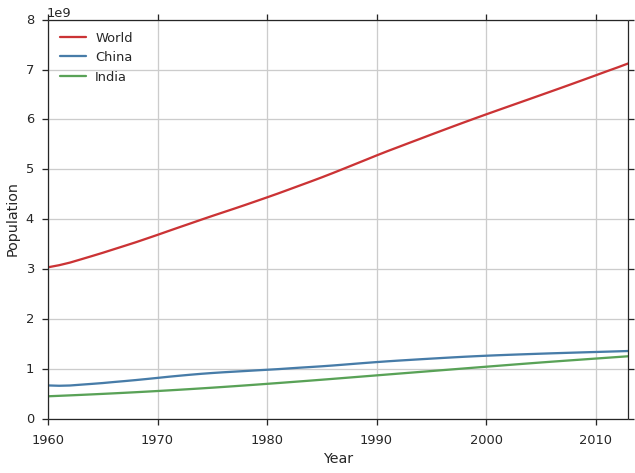

In [11]:
ax = world.plot('Year', 'Population')
china.plot('Year', 'Population', ax=ax)
india.plot('Year', 'Population', ax=ax)
ax.legend(['World', 'China', 'India'], loc='upper left')
ax.set_ylabel('Population');

## Exponential growth

According to [Malthus](http://en.wikipedia.org/wiki/Thomas_Robert_Malthus) (but that was a long time ago, so don't count on it!), populations grow exponentialy:

$$
\frac{dN(t)}{dt} = r N(t) \Rightarrow \\
N(t) = N(0) e^{rt} \Rightarrow \\
\log{N(t)} = \log{N(0)} + rt
$$

That means that that logarithm of the population should be a linear function of time. 

Let's check it. First define a new column for the log of the population size:

In [12]:
df['LogPopulation'] = np.log(df.Population)

Let's concentrate on the [G8 countires](http://en.wikipedia.org/wiki/G8) (well, not exactly, but good enough for the purpose of this presentation):

In [13]:
G8_countries = ('France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States', 'Canada', 'European Union') # 'Russian Federation' was suspended in 2014
G8 = df[df['Country Name'].isin(G8_countries)]
G8.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population,LogPopulation
33,Canada,CAN,"Population, total",SP.POP.TOTL,1960,17909009,16.700814
52,Germany,DEU,"Population, total",SP.POP.TOTL,1960,72814900,18.103431
69,European Union,EUU,"Population, total",SP.POP.TOTL,1960,409331746,19.830037
73,France,FRA,"Population, total",SP.POP.TOTL,1960,46647521,17.658130
77,United Kingdom,GBR,"Population, total",SP.POP.TOTL,1960,52400000,17.774417


Here we do a trick to sort the countires names based on the largest population in 2013:

In [15]:
G8_countries = G8.groupby('Country Name').Population.max()
G8_countries.sort(ascending=False)
G8_countries = G8_countries.index
print(G8_countries)

Index(['European Union', 'United States', 'Japan', 'Germany', 'France', 'United Kingdom', 'Italy', 'Canada'], dtype='object')


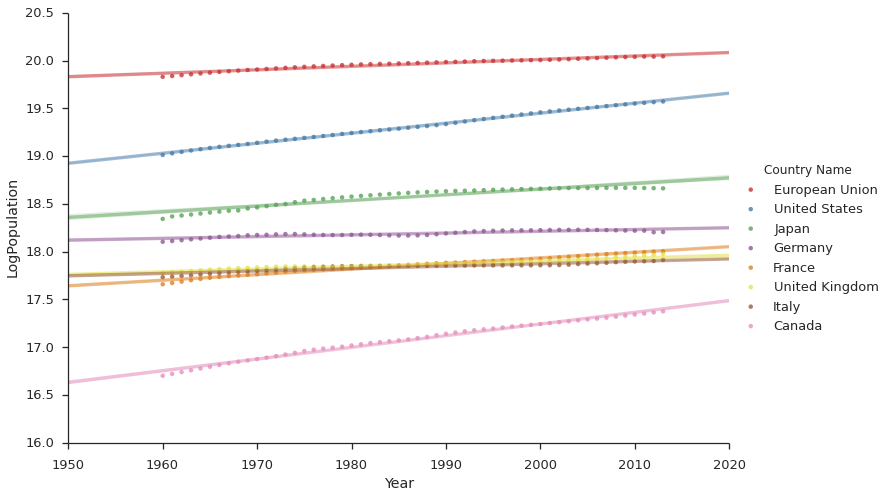

In [17]:
sns.lmplot(x='Year', y='LogPopulation', data=G8, hue='Country Name', 
           size=7, aspect=1.5, line_kws={'alpha':0.5}, hue_order=G8_countries);

This is interesting. While some countries fit very well to the Malthusian model (United States, France, United Kingdom), some countries don't fit as well: Japan seems to have stopped growing during the 1980's, and, European Union, Italy and Canada also seem to decelerate their growth. But this can be due to these countires being "developed". What about some "developing" countries?

Let's focus on the four largest countries, only one of the is "developed", but as we saw above it fits the Malthusian model.
We will use _SciPy_'s [`linregress`](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) function to perform linear regression. This will allow us to **extrapolate** - to predict what will be the population of these countries if the rate at which they grow remain constant under the Malthusian model. 

Note that the linear regression of `y` as a function of `x` is $y = a x + b$, where $a$ is the slope of the regression and $b$ is the interception. But then we have to exponentiate both sides of the equation as we want actual population size and not log population - so we get $e^y = e^{ax+b}$.

Let's extrapolate to the end of the century:

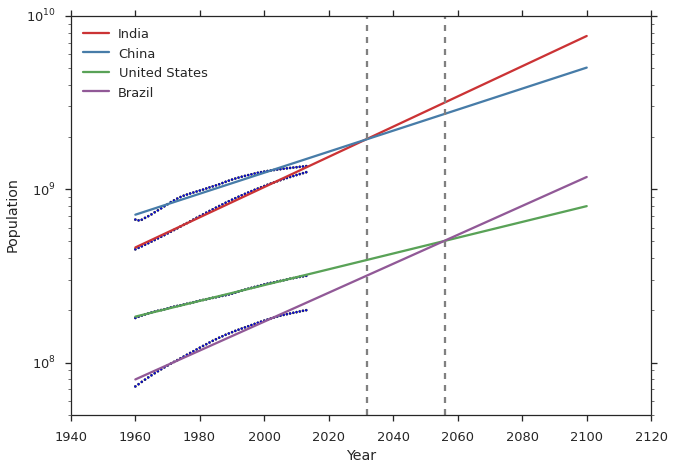

In [44]:
years = np.linspace(df.Year.min(), 2100)
for cn in ('India','China','United States', 'Brazil'):
    country = df[df['Country Name'] == cn]
    slope, intercept, r_value, p_value, std_err = linregress(country.Year, country.LogPopulation)    
    population = np.exp(intercept + slope * years)
    plt.plot(years, population, label=cn) # prediction
    plt.scatter(country.Year, country.Population, marker='.') #data
plt.xlabel('Year')
plt.ylabel('Population')
plt.yscale('log')
plt.ylim(5e7,1e10)
plt.legend(loc='upper left')
plt.axvline(x=2032, color='gray', linestyle='--')
plt.axvline(x=2056, color='gray', linestyle='--');

From our prediction, India will pass China around 2032 and Brazil will pass United States around 2056. Of course, from the estimated slopes and interceptions we can give an accurate prediction and estimate confidence intervals - but we won't do it here.

## Logistic growth

The Malthusian/exponential growth model can't always be correct -- many times growth decelerates and effectively stops when reaching a certain size _K_ (carrying capacity, maximum yield, maximum population density etc.). This is true for fish body size (Schnute 1981), microbial population size in a constant volume (Zwietering 1990), and natural animal populations. In these cases it is common to use the [**logistic growth model**](http://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth):

$$
\frac{dN}{dt} = r N \Big( 1 - \frac{N}{K} \Big)
$$

Let's start by plotting the solution to this _ordinary differential equation_ (ODE).
We need to define the ODE as a function of _N_, _t_ and whatever other parameters are needed. It is important that _N_ comes before _t_:

In [1]:
def logistic_ode(N, t, r, K):
    return r * N * (1 - N / K)

Integrating ODEs is really easy with Python. After defining the ODE function we can define a new function than given _t_, _r_, _K_ and $N_0$ (initial population size) calculates $N(t)$ by integration. For this we use _SciPy_'s `odeint` (ODE integration).

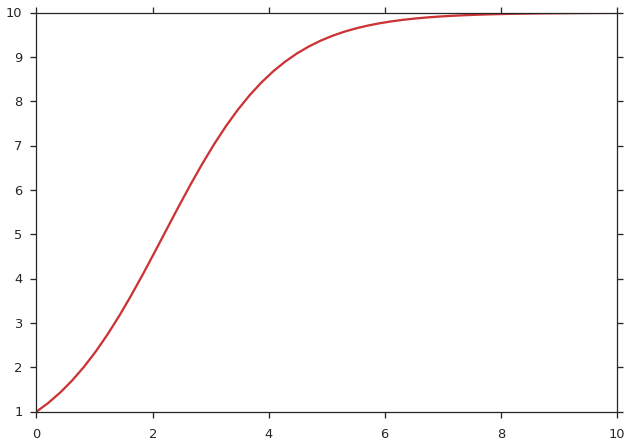

In [4]:
def integrate_logistic(t, N0, r, K):
    N = odeint(logistic_ode, N0, t, args=(r, K))
    return N

t = np.linspace(0,10)
N = integrate_logistic(t, N0=1, r=1, K=10)
plt.plot(t, N);

Incredibly, there is a solution to the [logistic equation](http://en.wikipedia.org/wiki/Logistic_function) that doesn't require integration:

$$
\frac{dN}{dt} = r N(t)(1 - N/K) \Rightarrow \\
N(t) = \frac{K N_0 e^{rt}}{K + N_0(e^{rt}-1)}
$$

In [7]:
def logistic(t, N0, r, K):
    return K * N0 * np.exp(r*t) / ( K + N0 * (np.exp(r*t) - 1))

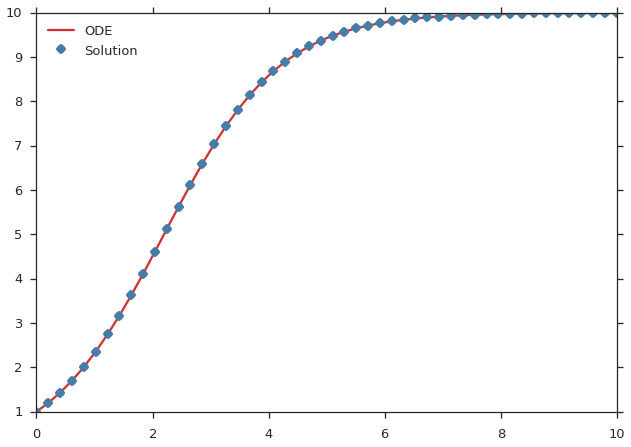

In [8]:
t = np.linspace(0,10)
N_integration = integrate_logistic(t, 1, 1, 10)
N_solution = logistic(t, 1, 1, 10)
plt.plot(t, N_integration, label='ODE')
plt.plot(t, N_solution, 'o', label='Solution')
plt.legend(loc='upper left');

## Fitting a logistic model 

So we have a standard growth model, but how do we find the right model (_i.e._ parameters) for our data? To do this we need to **fit the logistic model** to our data. 

We will use a _SciPy_ function called [`curve_fit`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.curve_fit.html) that accepts a model (a function of `t` and some other arguments==parameters that returns `N`), data (`t` and `N`), initial guesses of the model parameters, and some other optional arguments. It evaluates the model with the initial guesses and calculates the _fit_ of the result -- in standrad fitting this is done by the sum of the square of the differences between the model and the data. It then makes another guess of the model parameters, evaluates the model result and calculates the distance, and again and again. It stops when it reaches a minimal distance, and that's why this operation is called **least squares**. This operation isn't perfect, and when there are even just 3 or 4 model parameters there might be more than one minimum or the function might not find a minimum in a reasonable time.

### Simulated data

Before we try to work with real data we want to [try it with simulated data](http://stackoverflow.com/a/16241965/1063612) and see that we know what we are doing. 
To simulate data we generate data from the logistic function and add some normally distributed noise:

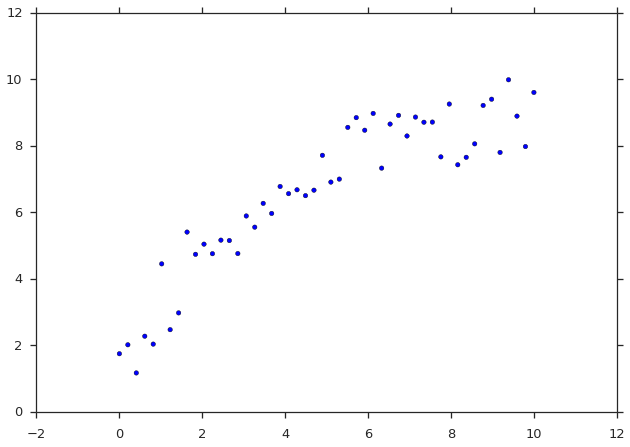

In [20]:
simulated = logistic(t, N0=1.5, r=0.75, K=8.5) +  np.random.normal(0, 0.7, t.shape)
plt.scatter(t, simulated);

Now we can call `curve_fit` and give it the simulated data and get back an estimate of the model parameters. As you can see, although there is a lot of noise, we can a pretty good estimate of the parameters.

N0=1.927, r=0.604, K=8.848


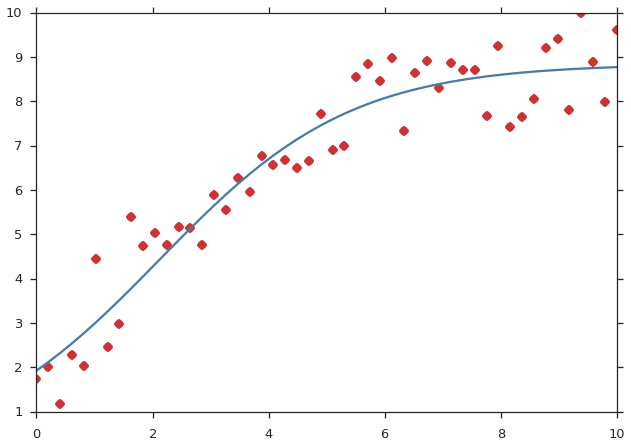

In [25]:
params, cov = curve_fit(logistic, t, simulated, (1,1,10))
N0,r,K = params
plt.plot(t, simulated, 'o')
plt.plot(t, logistic(t, N0, r, K), '-')
print('N0=%.3f, r=%.3f, K=%.3f' % (N0,r,K))

We can also get confidence intervals for the parameter values from the `cov` return value. But if you need to work with confidence interals you might prefer to work with the package [lmfit](http://lmfit.github.io/lmfit-py/) which has many benefits over _SciPy_'s `curve_fit`.

## Real data



In [27]:
!ls

CHANGES.md
Class exercise solutions.ipynb
LICENSE.md
README.md
Untitled.ipynb
aa_weights.txt
agg.csv
anage_dataset.zip
files_for_hw4
files_for_hw4.rar
fit lotka volterra.ipynb
harelynx.txt
hw1.ipynb
hw2.ipynb
hw3.ipynb
hw4.ipynb
hw5.ipynb
inflammation-01.csv
ipynb.bat
ipython_notebook.bat
lec1_images
lec4_files
lec4_files.rar
lec6_files
lec6_files.rar
lecture1.ipynb
lecture1.slides.html
lecture10.ipynb
lecture2.ipynb
lecture3.ipynb
lecture4.ipynb
lecture5.ipynb
lecture6.ipynb
lecture7.ipynb
lecture8.ipynb
solution1.ipynb
solution2.ipynb
solution3.ipynb
template.ipynb
world_growth.zip


In [29]:
df = pd.read_csv('Yoav_311214c_only_OD.csv')
df.head()

,Cycle Nr.,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,Time [s],0.0000,1136.9000,2273.7000,3410.5000,4547.4000,5684.2000,6821.0000,7957.8000,9094.6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Temp. [°C],37.2000,37.4000,37.3000,37.3000,36.9000,37.0000,37.3000,36.9000,37.3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A1,0.1128,0.1164,0.1221,0.1315,0.1451,0.1639,0.1841,0.2085,0.2298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A2,0.1118,0.1151,0.1260,0.1405,0.1464,0.1696,0.1901,0.2172,0.2396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A3,0.1186,0.1189,0.1242,0.1335,0.1467,0.1662,0.1880,0.2145,0.2374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = df.transpose()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
1,0,37.2,0.1128,0.1118,0.1186,0.1213,0.1131,0.1111,0.1178,0.1151,...,0.1173,0.124,0.1352,0.1266,0.1147,0.1157,0.1084,0.1177,0.1217,0.111
2,1136.9,37.4,0.1164,0.1151,0.1189,0.1209,0.1173,0.1144,0.1221,0.122,...,0.1189,0.1229,0.1386,0.1289,0.1154,0.1211,0.1103,0.1216,0.1208,0.113
3,2273.7,37.3,0.1221,0.126,0.1242,0.1251,0.1247,0.1222,0.1312,0.129,...,0.1295,0.135,0.1431,0.1373,0.1219,0.1258,0.1175,0.1276,0.1408,0.108
4,3410.5,37.3,0.1315,0.1405,0.1335,0.1338,0.1342,0.1321,0.1469,0.1377,...,0.1298,0.1586,0.1493,0.1455,0.1362,0.1349,0.1263,0.1374,0.1777,0.1104


In [31]:
# http://stackoverflow.com/questions/26147180/convert-row-to-column-header-for-pandas-dataframe
df.columns = df.iloc[0]
df.head()

Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
1,0,37.2,0.1128,0.1118,0.1186,0.1213,0.1131,0.1111,0.1178,0.1151,...,0.1173,0.124,0.1352,0.1266,0.1147,0.1157,0.1084,0.1177,0.1217,0.111
2,1136.9,37.4,0.1164,0.1151,0.1189,0.1209,0.1173,0.1144,0.1221,0.122,...,0.1189,0.1229,0.1386,0.1289,0.1154,0.1211,0.1103,0.1216,0.1208,0.113
3,2273.7,37.3,0.1221,0.126,0.1242,0.1251,0.1247,0.1222,0.1312,0.129,...,0.1295,0.135,0.1431,0.1373,0.1219,0.1258,0.1175,0.1276,0.1408,0.108
4,3410.5,37.3,0.1315,0.1405,0.1335,0.1338,0.1342,0.1321,0.1469,0.1377,...,0.1298,0.1586,0.1493,0.1455,0.1362,0.1349,0.1263,0.1374,0.1777,0.1104


In [32]:
df.drop(df.index[0], axis=0, inplace=True)
df.head()

Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
1,0,37.2,0.1128,0.1118,0.1186,0.1213,0.1131,0.1111,0.1178,0.1151,...,0.1173,0.124,0.1352,0.1266,0.1147,0.1157,0.1084,0.1177,0.1217,0.111
2,1136.9,37.4,0.1164,0.1151,0.1189,0.1209,0.1173,0.1144,0.1221,0.122,...,0.1189,0.1229,0.1386,0.1289,0.1154,0.1211,0.1103,0.1216,0.1208,0.113
3,2273.7,37.3,0.1221,0.126,0.1242,0.1251,0.1247,0.1222,0.1312,0.129,...,0.1295,0.135,0.1431,0.1373,0.1219,0.1258,0.1175,0.1276,0.1408,0.108
4,3410.5,37.3,0.1315,0.1405,0.1335,0.1338,0.1342,0.1321,0.1469,0.1377,...,0.1298,0.1586,0.1493,0.1455,0.1362,0.1349,0.1263,0.1374,0.1777,0.1104
5,4547.4,36.9,0.1451,0.1464,0.1467,0.147,0.1486,0.1465,0.1584,0.1533,...,0.1402,0.15,0.1622,0.1593,0.1481,0.1477,0.1385,0.1554,0.1537,0.1089


In [33]:
df.tail()

Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df.dropna(inplace=True)
df.tail()

Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
48,53430.7,37.2,0.5653,0.5967,0.5996,0.6016,0.5704,0.5309,0.5873,0.511,...,0.5433,0.5628,0.5642,0.5356,0.5927,0.5462,0.4917,0.604,0.5677,0.1123
49,54567.5,37.1,0.5622,0.5932,0.5986,0.6001,0.5677,0.5267,0.5843,0.5093,...,0.5406,0.5591,0.5595,0.5315,0.5885,0.5434,0.4864,0.5999,0.5725,0.1111
50,55704.3,36.9,0.5595,0.5912,0.595,0.5968,0.5645,0.5215,0.5814,0.5074,...,0.532,0.5558,0.5568,0.5273,0.5871,0.5378,0.482,0.599,0.5696,0.1118
51,56841.1,37,0.557,0.5884,0.5953,0.5949,0.5619,0.5169,0.5779,0.5059,...,0.5278,0.5515,0.5541,0.5249,0.5879,0.5346,0.4781,0.5963,0.5701,0.1128
52,57978,37.2,0.5545,0.5841,0.5914,0.5921,0.5587,0.5124,0.5751,0.5048,...,0.5267,0.5494,0.5499,0.5212,0.5825,0.5306,0.4736,0.5911,0.5599,0.1122


In [35]:
df['Time [h]'] = df['Time [s]'] / 3600 # 3600 seconds in one hour
df.head()

Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,A8,...,H4,H5,H6,H7,H8,H9,H10,H11,H12,Time [h]
1,0,37.2,0.1128,0.1118,0.1186,0.1213,0.1131,0.1111,0.1178,0.1151,...,0.124,0.1352,0.1266,0.1147,0.1157,0.1084,0.1177,0.1217,0.111,0
2,1136.9,37.4,0.1164,0.1151,0.1189,0.1209,0.1173,0.1144,0.1221,0.122,...,0.1229,0.1386,0.1289,0.1154,0.1211,0.1103,0.1216,0.1208,0.113,0.3158056
3,2273.7,37.3,0.1221,0.126,0.1242,0.1251,0.1247,0.1222,0.1312,0.129,...,0.135,0.1431,0.1373,0.1219,0.1258,0.1175,0.1276,0.1408,0.108,0.6315833
4,3410.5,37.3,0.1315,0.1405,0.1335,0.1338,0.1342,0.1321,0.1469,0.1377,...,0.1586,0.1493,0.1455,0.1362,0.1349,0.1263,0.1374,0.1777,0.1104,0.9473611
5,4547.4,36.9,0.1451,0.1464,0.1467,0.147,0.1486,0.1465,0.1584,0.1533,...,0.15,0.1622,0.1593,0.1481,0.1477,0.1385,0.1554,0.1537,0.1089,1.263167


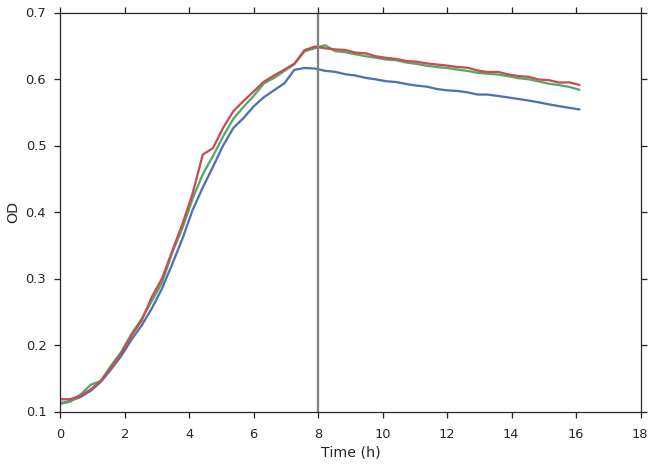

In [87]:
plot(df['Time [h]'], df['A1'], '-')
plot(df['Time [h]'], df['A2'], '-')
plot(df['Time [h]'], df['A3'], '-')
axvline(x=8, color='gray')
xlabel('Time (h)')
ylabel('OD');

In [88]:
df.A1.dtype, df['Time [h]'].dtype

(dtype('O'), dtype('O'))

In [90]:
df.A1 = df.A1.astype(float)
df['Time [h]'] = df['Time [h]'].astype(float)
df.A1.dtype, df['Time [h]'].dtype

(dtype('float64'), dtype('float64'))

In [91]:
t = df['Time [h]']
y = df.A1[t<8]
t = t[t<8]

In [92]:
r0 = (y.max()- y.min())/t.max()
r0

0.063853686724418213

r=0.578367, K=0.684, y0=0.079


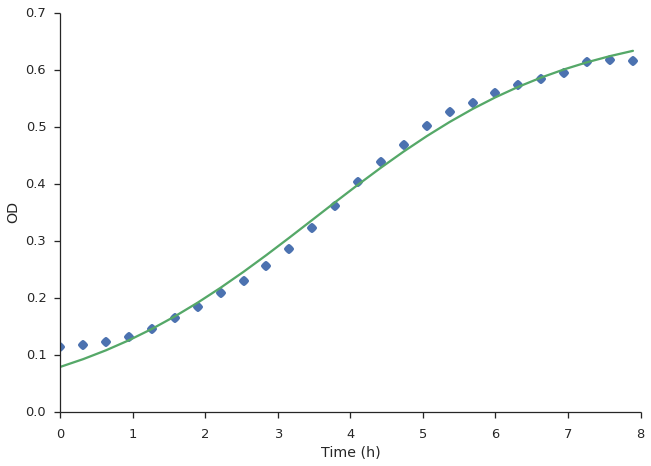

In [119]:
popt, cov = curve_fit(logistic, t, y, (r0, y.max(), y.min()))
r, K, y0 = popt
print('r=%.6f, K=%.3f, y0=%.3f' % (r,K,y0))
plot(t, y, 'o')
plot(t, logistic(t, r, K, y0), '-')
xlabel('Time (h)')
ylabel('OD')
sns.despine();

## Other functions

In [102]:
def logistic_lag(t, r, K, y0, t0):
    t = t-t0
    return K * y0 * exp(r*t) / ( K + y0 * (exp(r*t) - 1))

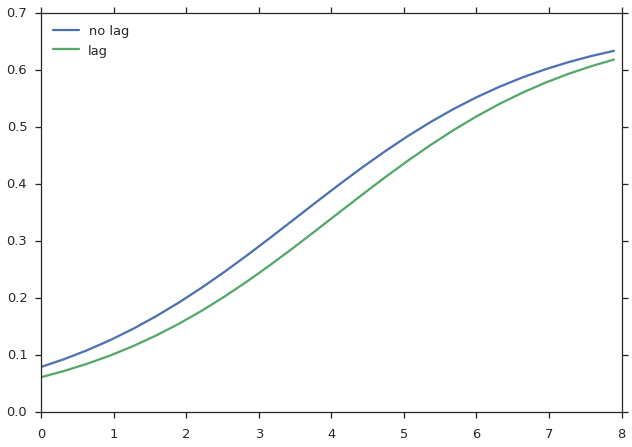

In [103]:
plot(t, logistic(t, r, K, y0), label='no lag')
plot(t, logistic_lag(t, r, K, y0, 0.5), label='lag')
legend(loc='upper left');

r=0.578367, K=0.684, y0=0.078, t0=-0.009


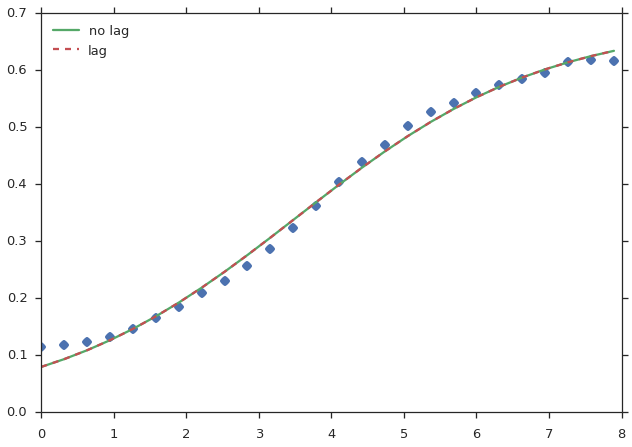

In [114]:
popt, cov = curve_fit(logistic_lag, t, y, (r0, y.max(), y.min(), 0))
rlag, Klag, y0lag, t0 = popt
print('r=%.6f, K=%.3f, y0=%.3f, t0=%.3f' % (rlag,Klag,y0lag,t0))
plot(t, y, 'o')
plot(t, logistic(t, r, K, y0), '-', label='no lag')
plot(t, logistic_lag(t, rlag, Klag, y0lag, t0), '--', label='lag')
legend(loc='upper left');

http://en.wikipedia.org/wiki/Gompertz_function

In [109]:
def gompertz(t, r, K, y0):
    return K * exp( log(y0/K) * exp(-r*t) )

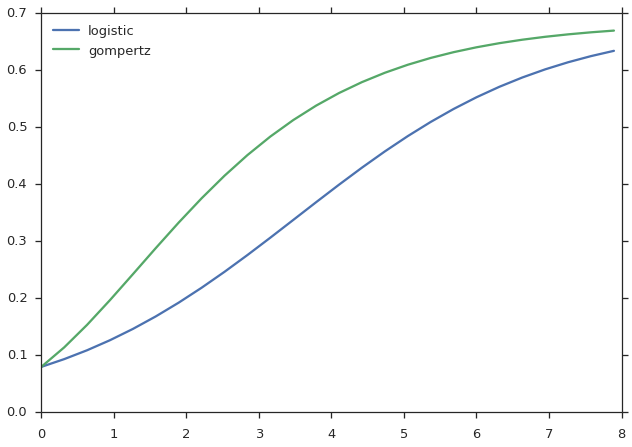

In [110]:
plot(t, logistic(t, r, K, y0), label='logistic')
plot(t, gompertz(t, r, K, y0), label='gompertz')
legend(loc='upper left');

r=0.301339, K=0.816, y0=0.068


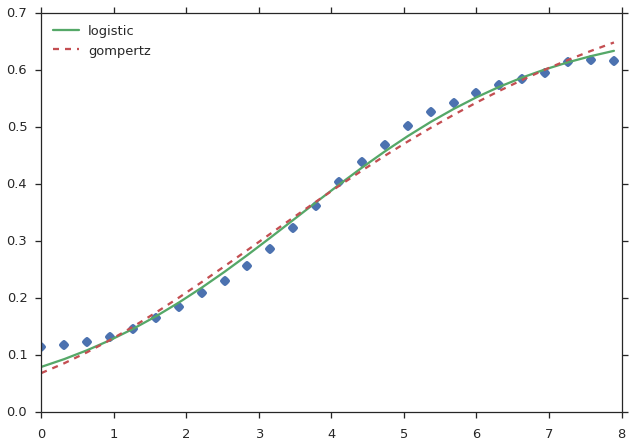

In [116]:
popt, cov = curve_fit(gompertz, t, y, (r0, y.max(), y.min()))
rgomp, Kgomp, y0gomp = popt
print('r=%.6f, K=%.3f, y0=%.3f' % (rgomp,Kgomp, y0gomp))
plot(t, y, 'o')
plot(t, logistic(t, r, K, y0), '-', label='logistic')
plot(t, gompertz(t, rgomp, Kgomp, y0gomp), '--', label='gompertz')
legend(loc='upper left');

http://en.wikipedia.org/wiki/Generalised_logistic_function

In [136]:
def richards(t, r, K, y0, nu):
    t0 = t.min()
    Q = -1 + (K/y0)**nu
    return K / ( 1 + Q * exp(-r * nu * (t-t0)) )**(1/nu)

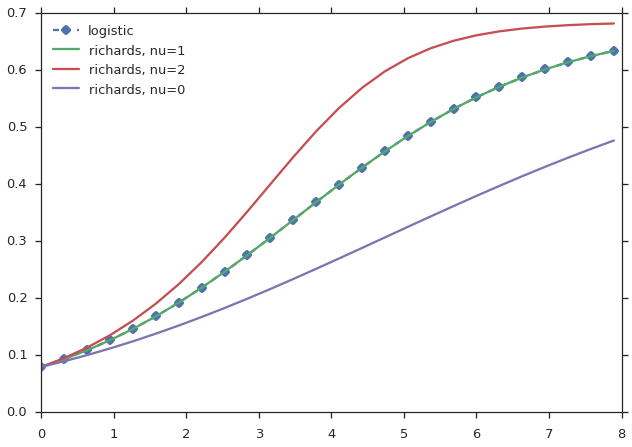

In [139]:
plot(t, logistic(t, r, K, y0), '--o', label='logistic')
plot(t, richards(t, r, K, y0, 1), label='richards, nu=1')
plot(t, richards(t, r, K, y0, 2), label='richards, nu=2')
plot(t, richards(t, r, K, y0, 0.5), label='richards, nu=0')
legend(loc='upper left');

r=0.364805, K=0.618, y0=0.095, nu=3.366


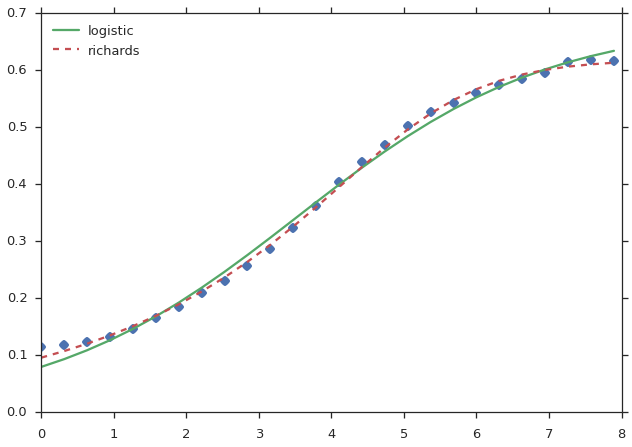

In [140]:
popt, cov = curve_fit(richards, t, y, (r0, y.max(), y.min(), 1))
rrich, Krich, y0rich, nurich = popt
print('r=%.6f, K=%.3f, y0=%.3f, nu=%.3f' % (rrich, Krich, y0rich, nurich))
plot(t, y, 'o')
plot(t, logistic(t, r, K, y0), '-', label='logistic')
plot(t, richards(t, rrich, Krich, y0rich, nurich), '--', label='richards')
legend(loc='upper left');

# References

- Schnute, J., 1981. A Versatile Growth Model with Statistically Stable Parameters. Can. J. Fish. Aquat. Sci. 38, 1128–1140.
- Zwietering, M.H., Jongenburger, I., Rombouts, F.M., van ’t Riet, K., 1990. Modeling of the bacterial growth curve. Appl. Environ. Microbiol. 56, 1875–81.

## Fin
This notebook is part of the _Python Programming for Life Sciences Graduate Students_ course given in Tel-Aviv University, Spring 2015.

The notebook was written using [Python](http://pytho.org/) 3.4.1 and [IPython](http://ipython.org/) 3.1.0 (download from [PyZo](http://www.pyzo.org/downloads.html)).

The code is available at https://github.com/Py4Life/TAU2015/blob/master/lecture10.ipynb.

The notebook can be viewed online at http://nbviewer.ipython.org/github/Py4Life/TAU2015/blob/master/lecture10.ipynb.

This work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)